# <span style="color:turquoise">**Detección de células redondas utilizando Yolo**</span>

## **Hardware**

**PC** Lenovo Idealpad Gaming3

**Procesador** AMD Ryzen 5 5600H with Radeon Graphics 3.3 GHz

	Velocidad de base:	3,30 GHz
	Sockets:	1
	Núcleos:	6
	Procesadores lógicos:	12
	Virtualización:	Habilitado
	Caché L1:	384 kB
	Caché L2:	3,0 MB
	Caché L3:	16,0 MB

**Gráficos dedicados** NVIDIA GeForce RTX 3050 Laptop 

	Versión del controlador:	31.0.15.5176
	Fecha del controlador:	01/03/2024
	Versión de DirectX:	12 (FL 12.1)
	Memoria de GPU dedicada	4,0 GB
	Memoria de GPU compartida	7,7 GB
	Memoria de GPU	11,7 GB
	
**RAM** 16 GB SODIMM DDR4 

	Velocidad:	3200 MHz
	Ranuras usadas:	2 de 2
	Factor de forma:	SODIMM

**Memoria estado sólido** SSD 512 GB 2210 NVMe PCIe Gen3 x4  Micron MTFDHBA512QFD

**Google Colab** 
	12.7 GB RAM, 15 GB RAM GPU Tesla T4, SSD 78.2 GB

In [1]:
!nvidia-smi

Wed Jul 23 01:08:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0              6W /   60W |     580MiB /   4096MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## **Introducción**

En este TFM se pretende realizar un estudio del arte y entrenamiento de diferentes modelos (YOLO, Fast-RCNN, propio) para la detección de células y artefactos en imágenes médicas. Para esto, se aplican técnicas de visión por computador y aprendizaje profundo. Además, se realizará un exahustiva revisión de la bibliografía existente, mejora del dataset y análisis estadistico fundamentado en las diferentes métricas.

## **Dependencias**

In [2]:
# %pip install -U ipywidgets jupyter
# %pip install ultralytics
# !pip install optuna

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import cv2
import json
import optuna
import shutil

import torch
from ultralytics import YOLO

from lib.YOLO_lib import config, optuna_utils, plot_utils, kfold_utils

In [2]:
print(f"Versión de PyTorch + CUDA: {torch.__version__}")
print(f"Diponible CUDA: {torch.cuda.is_available()}. \nDispositivo CUDA: {torch.cuda.get_device_name(0)}")

Versión de PyTorch + CUDA: 2.6.0+cu126
Diponible CUDA: True. 
Dispositivo CUDA: NVIDIA GeForce RTX 3050 Laptop GPU


## **Entrenamineto de los modelos YOLOv11 y YOLOv12**

### **Configuración**

In [3]:
selected_model = "yolo11s" 
model_dir = "yolo_output/yolo_models"
model_path = os.path.join(model_dir, f"{selected_model}.pt")

if selected_model not in config.models:
    model = YOLO(f"{selected_model}.pt")

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    if not os.path.exists(model_path):
        shutil.move(f"{selected_model}.pt", model_path)
else:
    model = YOLO(config.models[selected_model])

Recuerda que si hemos descargado un nuevo modelo, debemos añadirlo al archivod e configuración.

In [4]:
storage_name = f"sqlite:///optuna/optuna_studies/{selected_model}.db"
best_params_path = f"optuna/optuna_studies/{selected_model}_best_params.json"
image_optuna_path = f'optuna/optuna_plots/optimization_{selected_model}.png'
model_output = f"final_model_{selected_model}"
model_output_kfold = model_output + "_kfold"

### **Optuna**

In [ ]:
study = optuna.create_study(
    direction="maximize",  # Maximizar mAP@0.5:0.95
    study_name=selected_model,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed = config.SEED)  
)

study.optimize(lambda trial: optuna_utils.optuna_objective(trial, model, selected_model), n_trials=config.N_TRIALS, timeout=None)

print("Número de trials completados:", len(study.trials))

with open(best_params_path, 'w') as f:
    json.dump(study.best_trial.params, f, indent=2)

[I 2025-07-24 00:18:57,801] A new study created in RDB with name: yolo11s


New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005611516415334506, lrf=0.00892718030435363, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo_output/yolo_models/yolo11s.yaml, momentum=0.9097990912717108, mosaic=0, mul

100%|██████████| 5.35M/5.35M [00:00<00:00, 26.3MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.20.1 ms, read: 150.213.1 MB/s, size: 105.3 KB)


train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.1 ms, read: 154.022.5 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\optuna_trial_yolo11s_0\labels.jpg... 
optimizer: SGD(lr=0.0005611516415334506, momentum=0.9097990912717108) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00037207437472915983), 87 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\optuna_trial_yolo11s_0
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      3.13G      6.634      21.18      5.221        159        704: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all         70        889          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/25       3.2G      6.765      13.83      5.269        138        704: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

                   all         70        889          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/25      3.08G      6.706      9.318      5.087        145        704: 100%|██████████| 28/28 [00:12<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all         70        889          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/25      3.03G       6.85       10.2      4.957        170        704:  32%|███▏      | 9/28 [00:04<00:08,  2.21it/s]

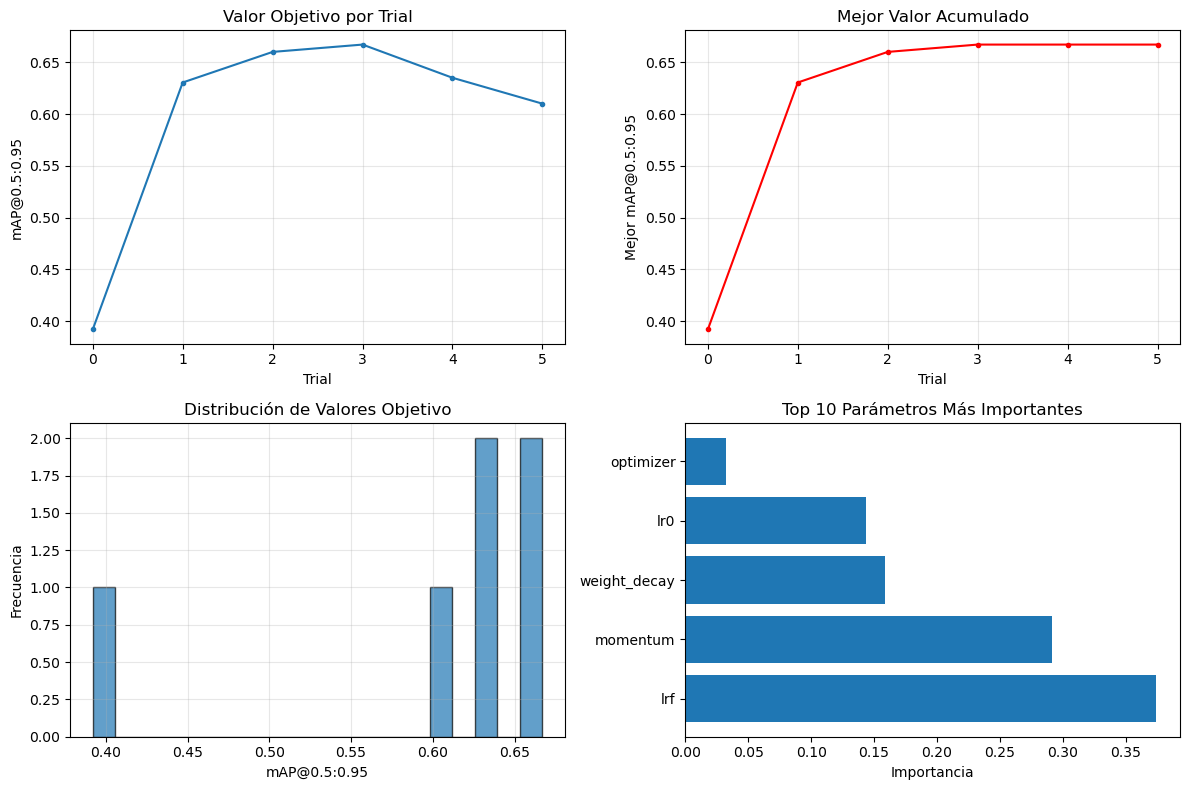

In [8]:
%matplotlib inline
optuna_utils.optuna_optimization_history(study, output_path=image_optuna_path)

In [5]:
with open(f"optuna/optuna_studies/{selected_model}_best_params.json", "r") as f:
    best_params = json.load(f)

print("Mejores hiperparámetros:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

Mejores hiperparámetros:
  lr0: 0.00019010245319870352
  lrf: 0.001959497205867916
  momentum: 0.8549542764940538
  weight_decay: 0.0002858051065806936
  optimizer: SGD


### **K-Fold Cross Validation**

Se concatena train y val para tener un dataset mayor para k-fold 350 imagenes en 5 folds.

In [ ]:
metrics_df = kfold_utils.train(model, best_params, model_output_kfold)


Entrenando fold_1 (1/5)
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_1\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.8549542764940538, 

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 668.81it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 6.01.4 MB/s, size: 93.3 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_1\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 382.30it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_1\val\labels.cache


Plotting labels to runs\detect\final_model_yolov9s_kfold\fold_1\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002679422874194002), 227 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov9s_kfold\fold_1
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.86G      0.932     0.6977     0.8495         78        704: 100%|██████████| 28/28 [00:30<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

                   all         70        870      0.796      0.878      0.897      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.62G     0.9456     0.7021     0.8561         69        704: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.797      0.883      0.897      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.67G     0.9483     0.6961     0.8517        131        704: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        870      0.794      0.887      0.897      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.57G     0.9231     0.6936     0.8566        138        704: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        870      0.795      0.878      0.897      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.58G      0.945     0.7004     0.8496        131        704: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        870      0.792      0.876      0.896      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.73G     0.9435     0.6955     0.8551         99        704: 100%|██████████| 28/28 [00:30<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        870      0.799      0.866      0.894      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.61G     0.9158     0.6865     0.8519        139        704: 100%|██████████| 28/28 [00:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all         70        870      0.797      0.868      0.894      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.68G     0.9331     0.6829     0.8603        199        704: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        870      0.803      0.869      0.899      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.69G     0.9091     0.6817     0.8518        112        704: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]

                   all         70        870      0.807      0.867      0.902      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.64G     0.9389      0.696     0.8552        176        704: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        870      0.806      0.866      0.899      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.59G      0.941     0.7036     0.8669         97        704: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        870      0.803      0.862        0.9      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.67G     0.9273     0.7019       0.85        148        704: 100%|██████████| 28/28 [00:23<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

                   all         70        870      0.804      0.875      0.899      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.65G     0.9175     0.6821     0.8454         92        704: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

                   all         70        870      0.797      0.876      0.898      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.66G     0.9341     0.6914     0.8509         89        704: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        870      0.798      0.876      0.897      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.68G     0.9058     0.6667     0.8458        208        704: 100%|██████████| 28/28 [00:27<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        870      0.799      0.875      0.897      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.69G     0.8955     0.6678     0.8469        117        704: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        870      0.794      0.877      0.897      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.61G      0.947     0.7009     0.8531        101        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.796      0.879      0.899      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.63G      0.913     0.6777     0.8503        130        704: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.795       0.88      0.898       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.55G     0.9146     0.6834     0.8478        172        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        870      0.795      0.884      0.899      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.68G     0.9012     0.6717     0.8462        121        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all         70        870      0.792      0.883        0.9      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60       3.6G     0.9201      0.679     0.8499        162        704: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        870      0.798      0.879        0.9      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.68G     0.9394     0.6814     0.8559         85        704: 100%|██████████| 28/28 [00:21<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        870      0.801      0.877      0.902      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.63G     0.9366     0.6971     0.8524         63        704: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        870      0.803      0.875        0.9      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       3.7G      0.908     0.6699     0.8465        206        704: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        870      0.806      0.874      0.901      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.63G     0.9164     0.6718     0.8521        228        704: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.799      0.877      0.901      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.58G     0.9257     0.6761     0.8542         78        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        870      0.797      0.879      0.899      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.63G     0.9231     0.6899     0.8546        129        704: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all         70        870      0.798       0.88        0.9      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.67G     0.9051     0.6852     0.8445        112        704: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all         70        870      0.795       0.88        0.9      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.68G     0.9093     0.6859     0.8415         40        704: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        870      0.795      0.878      0.898      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.57G     0.9391     0.6871     0.8515        210        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        870      0.797      0.881        0.9      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.59G      0.908     0.6837     0.8461         77        704: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        870      0.797      0.882      0.899        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.68G     0.9642     0.6955      0.861        136        704: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        870      0.798      0.882      0.899      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.68G     0.9228     0.6748     0.8457        119        704: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]

                   all         70        870      0.795      0.877      0.898      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60       3.7G     0.9278     0.6871     0.8502        132        704: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        870      0.796      0.879      0.899      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.67G     0.9087     0.6811     0.8569        111        704: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.797      0.876      0.898      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.64G     0.9187     0.6778     0.8459        155        704: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        870        0.8      0.876      0.897       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.65G     0.9347     0.6903      0.851         75        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

                   all         70        870      0.796      0.881        0.9      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.68G     0.9433     0.6779     0.8536         77        704: 100%|██████████| 28/28 [00:27<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        870      0.796       0.88      0.898      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.67G     0.9382      0.681     0.8476        151        704: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all         70        870      0.799      0.879      0.897        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.62G      0.954     0.6915     0.8552        130        704: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all         70        870      0.801      0.878      0.897      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60       3.7G     0.9127     0.6824     0.8514        123        704: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.797      0.878      0.897       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.57G     0.8984     0.6745     0.8468        149        704: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70        870      0.797      0.878      0.896      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.57G      0.965     0.7112     0.8556         86        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        870      0.796      0.875      0.897      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.65G     0.8915     0.6557     0.8431        111        704: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all         70        870      0.802      0.875      0.899      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.68G     0.8746      0.669     0.8503        178        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        870      0.798      0.878      0.899      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.63G     0.9288     0.6882     0.8524        113        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        870      0.796      0.882      0.901      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.69G     0.9314     0.6857     0.8558        152        704: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        870      0.799      0.877      0.899      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.64G     0.9308     0.6833     0.8504        110        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        870      0.801      0.877        0.9      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.63G     0.9491     0.6871     0.8519        174        704: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all         70        870        0.8      0.874      0.896      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.62G     0.9433     0.6876     0.8566        179        704: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        870      0.801      0.877      0.899      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.59G     0.9085     0.6988      0.848        132        704: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        870      0.803      0.875        0.9      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.63G     0.8976     0.6682       0.85        106        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        870      0.798      0.879        0.9      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.64G     0.9279     0.6885      0.853        131        704: 100%|██████████| 28/28 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        870      0.798       0.88      0.899      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60       3.7G     0.9098     0.6863     0.8428        114        704: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        870      0.796      0.882      0.899      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.62G     0.9464     0.6771     0.8619         72        704: 100%|██████████| 28/28 [00:19<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        870        0.8      0.877      0.899      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.63G     0.9341     0.6799      0.857        173        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all         70        870      0.799      0.879        0.9      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.67G     0.9132     0.6729     0.8582        125        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        870      0.798       0.88        0.9      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.61G     0.9266     0.6741     0.8491        127        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        870      0.802      0.874      0.901      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.63G     0.9369     0.6914     0.8571        166        704: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all         70        870      0.801      0.876      0.902      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.62G     0.9232     0.6689     0.8505         81        704: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        870      0.798       0.88        0.9      0.615



60 epochs completed in 0.403 hours.
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_1\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_1\weights\best.pt, 15.2MB

Validating runs\detect\final_model_yolov9s_kfold\fold_1\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all         70        870      0.793      0.884      0.899      0.627
Speed: 0.5ms preprocess, 16.3ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs\detect\final_model_yolov9s_kfold\fold_1

Entrenando fold_2 (2/5)
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_2\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, 

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 667.63it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 5.41.7 MB/s, size: 86.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_2\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 351.82it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_2\val\labels.cache


Plotting labels to runs\detect\final_model_yolov9s_kfold\fold_2\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002679422874194002), 227 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov9s_kfold\fold_2
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.76G     0.8873     0.6793     0.8461        142        704: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         70       1019      0.854       0.88      0.916      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.65G     0.8983     0.6919     0.8455         43        704: 100%|██████████| 28/28 [00:30<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70       1019      0.854      0.879      0.916      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.69G     0.9689     0.7077     0.8591        166        704: 100%|██████████| 28/28 [00:27<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all         70       1019       0.85      0.879      0.915      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.63G     0.9196     0.6786     0.8514        131        704: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70       1019      0.855      0.875      0.916      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.57G     0.9551      0.713     0.8352         61        704: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70       1019      0.854      0.882      0.917      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.67G     0.9432     0.6885     0.8495        109        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70       1019      0.854       0.88      0.916      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.59G     0.9372      0.696     0.8498        103        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70       1019      0.853      0.881      0.918      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.67G     0.9181     0.6962     0.8514        166        704: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70       1019      0.856      0.879      0.917      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.63G     0.9441     0.6876      0.853        107        704: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.857      0.879      0.918      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.67G     0.9332     0.6921     0.8523        136        704: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70       1019      0.854      0.876      0.918      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.62G     0.8979     0.6854     0.8544        149        704: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70       1019      0.858      0.878       0.92      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.66G     0.9599     0.7065     0.8612        106        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019      0.854      0.877      0.918      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.64G     0.9266     0.6874     0.8446        140        704: 100%|██████████| 28/28 [00:17<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019      0.858      0.876      0.918      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.67G     0.9493     0.6956     0.8511         77        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70       1019       0.86      0.878      0.918      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.57G     0.9007     0.6985     0.8437         87        704: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70       1019      0.862      0.878      0.917      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.59G     0.8906     0.6841     0.8476        125        704: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70       1019       0.86      0.877      0.917      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.65G     0.9264      0.698     0.8455        121        704: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019      0.861      0.875      0.917      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.68G      0.905     0.6671     0.8467        143        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         70       1019      0.862      0.877      0.918      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.62G     0.9364     0.6893     0.8473        148        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70       1019      0.861      0.878      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.66G     0.8999     0.6812     0.8487         88        704: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70       1019       0.86      0.877      0.917      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.64G     0.9283     0.6818     0.8566        114        704: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70       1019      0.862      0.877      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.67G     0.9184      0.684     0.8451         93        704: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70       1019      0.861      0.876      0.918      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.55G     0.9049     0.6779     0.8487        109        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019      0.859      0.875      0.917      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.65G     0.9203     0.6907     0.8406        115        704: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70       1019      0.861      0.875      0.918      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.58G     0.9131     0.6769     0.8539        141        704: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70       1019      0.859      0.877      0.917       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.69G     0.9239     0.6724     0.8458         76        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70       1019       0.86      0.875      0.917      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.59G     0.9088     0.6787     0.8491        188        704: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.858      0.875      0.917      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.61G     0.9139     0.6854     0.8449         72        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.859      0.876      0.917       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.63G     0.9123      0.683     0.8454        100        704: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70       1019      0.856      0.876      0.917      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.61G     0.9329     0.6812     0.8523        131        704: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70       1019      0.855      0.876      0.917      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.59G     0.9265     0.6806     0.8462        122        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.854      0.876      0.917      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.64G      0.937     0.6887     0.8511         98        704: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70       1019      0.852      0.878      0.916       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.54G     0.9121      0.676     0.8541        123        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019       0.85      0.876      0.914      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.68G     0.9229     0.6912     0.8469        121        704: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.851      0.874      0.915      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.56G      0.922      0.685     0.8527         47        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70       1019      0.854      0.872      0.914      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.67G     0.9227     0.7041     0.8543        216        704: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.852      0.873      0.915      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.68G     0.9721     0.7053     0.8484        180        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70       1019      0.853      0.876      0.916      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.62G     0.9402     0.6991     0.8505        133        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70       1019      0.853      0.876      0.916      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.54G     0.9557     0.6935     0.8454        104        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70       1019      0.853      0.877      0.915      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.65G     0.9583     0.6893     0.8463        111        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         70       1019      0.855      0.876      0.916      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.58G     0.8805     0.6637     0.8437        124        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70       1019      0.855      0.877      0.915      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.67G     0.9028     0.6766     0.8493         82        704: 100%|██████████| 28/28 [00:29<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70       1019      0.855      0.876      0.916      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.59G     0.9276     0.6853     0.8449         85        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019      0.857      0.876      0.916      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.61G     0.9029     0.6908     0.8422        117        704: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70       1019      0.861      0.874      0.918      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.66G     0.8986      0.679     0.8469        184        704: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]

                   all         70       1019      0.859      0.875      0.917      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.57G     0.9234     0.6873     0.8473         63        704: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all         70       1019      0.858      0.874      0.918      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.64G      0.919     0.6847      0.844         88        704: 100%|██████████| 28/28 [00:24<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70       1019      0.854      0.874      0.916       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.66G     0.9171     0.6701     0.8524        148        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70       1019      0.852      0.875      0.916      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.68G     0.9328     0.6924     0.8588        105        704: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all         70       1019       0.85      0.877      0.914      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.68G      0.937      0.694     0.8486        104        704: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all         70       1019      0.849      0.876      0.916      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.64G     0.9079      0.684     0.8469         64        704: 100%|██████████| 28/28 [00:25<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70       1019      0.851      0.876      0.915      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.61G     0.9328     0.6879      0.853        102        704: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70       1019      0.854      0.876      0.916      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60       3.6G     0.9046     0.6783     0.8475         91        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all         70       1019       0.85      0.878      0.914      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60       3.6G     0.9277     0.6719     0.8503         94        704: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70       1019      0.844      0.879      0.914      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.62G     0.9368     0.6864     0.8403        118        704: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70       1019       0.85      0.878      0.914      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.69G       0.93     0.6883     0.8495         91        704: 100%|██████████| 28/28 [00:30<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all         70       1019      0.851      0.877      0.915      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.63G     0.9402     0.6979     0.8543        118        704: 100%|██████████| 28/28 [00:20<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]

                   all         70       1019      0.852      0.876      0.916      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.65G     0.9455     0.6926      0.853        119        704: 100%|██████████| 28/28 [00:20<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all         70       1019      0.853      0.876      0.917       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.64G     0.9063     0.6652      0.847        109        704: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70       1019      0.851      0.876      0.916      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.67G     0.9368     0.6703     0.8512         60        704: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         70       1019      0.852      0.876      0.916      0.625



60 epochs completed in 0.384 hours.
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_2\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_2\weights\best.pt, 15.2MB

Validating runs\detect\final_model_yolov9s_kfold\fold_2\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


                   all         70       1019      0.854      0.882      0.917      0.644
Speed: 0.7ms preprocess, 16.3ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs\detect\final_model_yolov9s_kfold\fold_2

Entrenando fold_3 (3/5)
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_3\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, 

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 658.43it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 4.91.1 MB/s, size: 95.1 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_3\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 272.41it/s]


val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_3\val\labels.cache
Plotting labels to runs\detect\final_model_yolov9s_kfold\fold_3\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002679422874194002), 227 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov9s_kfold\fold_3
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.83G     0.8921     0.6632     0.8402         92        704: 100%|██████████| 28/28 [00:32<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        986      0.786      0.871      0.872      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.65G     0.9128     0.6764     0.8477        100        704: 100%|██████████| 28/28 [00:24<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.796      0.865      0.873      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.66G      0.927     0.6854      0.843        202        704: 100%|██████████| 28/28 [00:28<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        986      0.797       0.87      0.875      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.69G     0.9019       0.67     0.8506        180        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        986      0.797      0.862      0.872      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.67G      0.923     0.6761     0.8403        118        704: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        986      0.794      0.869      0.874       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.64G     0.9312     0.6833     0.8532         71        704: 100%|██████████| 28/28 [00:29<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        986      0.793       0.87      0.874      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.62G     0.9234     0.6644     0.8506        136        704: 100%|██████████| 28/28 [00:26<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70        986      0.795       0.86      0.872      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.65G     0.9053     0.6809     0.8508        129        704: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        986      0.797      0.861      0.874      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.57G     0.9205      0.675     0.8446         80        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986      0.795      0.864      0.873      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.71G     0.9389     0.6797     0.8442        182        704: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]

                   all         70        986      0.792      0.868      0.874      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.69G     0.9269     0.6872     0.8511        112        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.793      0.867      0.874      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.58G     0.8877      0.662     0.8467        103        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        986      0.795      0.862      0.875      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.61G     0.9197     0.6763     0.8504        130        704: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986      0.794      0.868      0.875      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.68G     0.9619     0.7077     0.8597        140        704: 100%|██████████| 28/28 [00:27<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.794      0.862      0.874      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.62G     0.8779     0.6423     0.8445        204        704: 100%|██████████| 28/28 [00:18<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        986      0.794      0.861      0.875      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.68G     0.8905     0.6651     0.8424         69        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        986      0.796       0.86      0.874      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.71G     0.9033     0.6834     0.8417        127        704: 100%|██████████| 28/28 [00:23<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        986      0.798      0.861      0.876      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.64G     0.9308     0.6811     0.8557        143        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.799      0.863      0.877      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.61G     0.8993     0.6666     0.8524         83        704: 100%|██████████| 28/28 [00:17<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.801      0.859      0.876      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.66G     0.8977     0.6684     0.8458        175        704: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.799      0.862      0.876      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.58G     0.9198      0.672     0.8503        128        704: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        986      0.796      0.863      0.876      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.69G     0.9207     0.6683     0.8456         88        704: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.802      0.858      0.876      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.65G     0.9199     0.6785     0.8474         52        704: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        986      0.801       0.86      0.873      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60       3.6G      0.901     0.6616      0.844        192        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        986      0.803      0.859      0.875      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.68G     0.8923     0.6511     0.8443        136        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        986      0.799       0.86      0.874      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.62G     0.9178     0.6804     0.8535         73        704: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986      0.803      0.858      0.875        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.63G     0.9105     0.6702      0.854        131        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.805      0.859      0.876        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.67G     0.9169     0.6676     0.8463        100        704: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all         70        986      0.803      0.863      0.877      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.67G     0.9127     0.6775     0.8462         89        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.801      0.858      0.874      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.68G     0.9129     0.6775     0.8444        255        704: 100%|██████████| 28/28 [00:21<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        986      0.806      0.856      0.875      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.67G     0.9102     0.6631     0.8465        153        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all         70        986      0.797      0.858      0.875      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.74G     0.9248      0.688     0.8426         71        704: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        986      0.806      0.856      0.876      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.54G     0.9088     0.6684     0.8461         93        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        986      0.801      0.859      0.873      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.64G     0.9085     0.6795     0.8427         63        704: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        986      0.801      0.859      0.873      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.65G     0.9018     0.6893     0.8473        140        704: 100%|██████████| 28/28 [00:19<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70        986      0.797      0.858      0.874      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.54G     0.9285     0.6677     0.8512        132        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        986      0.803      0.855      0.875      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.57G     0.9132     0.6711     0.8405        142        704: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        986        0.8      0.857      0.878      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.58G     0.9218     0.6765     0.8441        100        704: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.802      0.858      0.877        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.74G     0.9341     0.6863     0.8543        141        704: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986      0.795      0.863      0.874      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.67G     0.9486     0.6845     0.8482         77        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        986      0.795      0.861      0.875      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60       3.6G     0.9254     0.6685     0.8656        109        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        986      0.804      0.857      0.874      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.58G      0.882     0.6597     0.8416        120        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        986      0.801      0.856      0.873       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.65G     0.9409     0.6827     0.8529         77        704: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        986        0.8       0.86      0.872      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.63G     0.8865     0.6603     0.8436        227        704: 100%|██████████| 28/28 [00:17<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        986      0.797      0.861      0.875      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.61G      0.875      0.653     0.8478        132        704: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.802      0.857      0.874      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.66G     0.9202     0.6665     0.8486        118        704: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all         70        986      0.795      0.862      0.875        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.68G     0.9168     0.6668     0.8472        169        704: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        986      0.797      0.862      0.874      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.56G     0.9182     0.6732      0.854         58        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986      0.799      0.861      0.876      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60       3.6G     0.9213     0.6679      0.858         87        704: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986      0.804      0.854      0.871      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.62G        0.9     0.6683     0.8451        203        704: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986      0.796       0.86      0.874      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.63G     0.9226     0.6844     0.8496         89        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        986      0.798      0.859      0.875      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.61G     0.9022     0.6616     0.8508        146        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        986      0.803      0.855      0.874      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.59G     0.9199     0.6737     0.8512         97        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.803      0.854      0.875      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.66G     0.9031     0.6578     0.8438        103        704: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        986        0.8      0.855      0.876      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.56G     0.9284     0.6664     0.8425        157        704: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        986        0.8       0.86      0.874      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.69G      0.902     0.6744       0.85        132        704: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        986        0.8      0.861      0.875      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.67G     0.8852     0.6645     0.8476         61        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all         70        986      0.797      0.862      0.876      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.69G     0.9051     0.6799     0.8493        205        704: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.799      0.861      0.876      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.69G     0.8982     0.6628     0.8466         99        704: 100%|██████████| 28/28 [00:21<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        986      0.795      0.865      0.877      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60       3.6G     0.9279     0.6641     0.8491        178        704: 100%|██████████| 28/28 [00:16<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        986      0.801      0.861      0.876      0.603



60 epochs completed in 0.389 hours.
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_3\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_3\weights\best.pt, 15.2MB

Validating runs\detect\final_model_yolov9s_kfold\fold_3\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


                   all         70        986      0.804      0.857      0.874      0.616
Speed: 0.8ms preprocess, 15.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs\detect\final_model_yolov9s_kfold\fold_3

Entrenando fold_4 (4/5)
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_4\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, 

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 709.63it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\train\labels.cache


val: Fast image access  (ping: 0.10.0 ms, read: 6.71.4 MB/s, size: 104.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_4\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 371.14it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_4\val\labels.cache


Plotting labels to runs\detect\final_model_yolov9s_kfold\fold_4\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002679422874194002), 227 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov9s_kfold\fold_4
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.76G     0.9061     0.6465     0.8482         87        704: 100%|██████████| 28/28 [00:29<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        992      0.826      0.838      0.891      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.66G     0.9126     0.6807     0.8533        127        704: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all         70        992       0.82      0.841      0.889      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.69G      0.922     0.6854     0.8458        128        704: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        992      0.826       0.84      0.892      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.61G     0.9405     0.6761     0.8576        104        704: 100%|██████████| 28/28 [00:21<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        992      0.824      0.838      0.891      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.69G     0.9224     0.6736     0.8432        113        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        992      0.822      0.843      0.892      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.57G     0.9078     0.6606     0.8504        107        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        992       0.82      0.842      0.887      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.66G      0.919     0.6779     0.8487        120        704: 100%|██████████| 28/28 [00:21<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         70        992      0.821      0.843      0.888      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.65G     0.9292     0.6777     0.8529        161        704: 100%|██████████| 28/28 [00:22<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992      0.823      0.847      0.891      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.68G     0.9258     0.6692     0.8507        172        704: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        992      0.825      0.848      0.892      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.64G     0.9453     0.6661     0.8533        108        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]

                   all         70        992      0.823      0.848      0.892      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.58G     0.8942     0.6669     0.8452         78        704: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        992       0.82      0.851      0.893      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.57G     0.9088     0.6655     0.8514        103        704: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        992      0.816      0.852      0.891      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.68G     0.9248     0.6671     0.8503        148        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        992      0.817      0.848      0.892      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.62G     0.9388     0.6724     0.8527        110        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        992       0.82      0.847      0.893      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.61G     0.9388     0.6704     0.8647        201        704: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        992      0.818       0.85      0.894      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.62G      0.905     0.6613     0.8435        110        704: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992      0.819      0.852      0.892       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.65G     0.9155     0.6726     0.8503         71        704: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992       0.82       0.85      0.891      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.57G     0.9261     0.6716     0.8473         79        704: 100%|██████████| 28/28 [00:17<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all         70        992      0.818      0.852      0.893      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.72G     0.9119     0.6716     0.8411         46        704: 100%|██████████| 28/28 [00:19<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        992      0.819      0.851      0.892       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.63G     0.9013      0.661     0.8459         85        704: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all         70        992      0.817      0.853       0.89      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.67G     0.9044      0.664     0.8489         80        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992      0.821      0.851       0.89      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.66G     0.9396     0.6821     0.8555         62        704: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        992      0.817       0.85       0.89      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.73G     0.9292     0.6753     0.8391         20        704: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all         70        992      0.813      0.857      0.889      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.66G     0.9035     0.6562     0.8437        153        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        992      0.813      0.857      0.889      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60       3.6G     0.8978     0.6622     0.8432        176        704: 100%|██████████| 28/28 [00:17<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992      0.823      0.849      0.894      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.58G     0.9265     0.6661     0.8581         80        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        992      0.819      0.853      0.893      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60       3.6G     0.9159     0.6677     0.8498        164        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        992      0.817      0.851      0.889      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.66G     0.9227     0.6659      0.846         66        704: 100%|██████████| 28/28 [00:20<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        992      0.817      0.852      0.893      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.59G     0.9135     0.6808     0.8526         73        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        992      0.822       0.84      0.888      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.54G     0.9085     0.6565     0.8445        161        704: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        992       0.82      0.845      0.889      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.57G      0.944     0.6697     0.8579         83        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        992      0.817      0.848      0.888      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.68G     0.9318     0.6689     0.8461        132        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        992      0.822      0.852      0.891      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.62G     0.9227     0.6675     0.8408         65        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        992      0.821       0.85      0.891      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.54G     0.9259     0.6677     0.8511         80        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        992      0.819      0.853      0.891       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.55G     0.9356     0.6745     0.8577        104        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        992      0.818      0.851      0.889      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.67G     0.9355     0.6744     0.8493        101        704: 100%|██████████| 28/28 [00:23<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        992       0.82       0.85       0.89       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.59G     0.9407     0.6714     0.8469        165        704: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992      0.816      0.851      0.891       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.65G     0.9148     0.6692     0.8502        109        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        992      0.812      0.851      0.885       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.64G      0.969     0.6932     0.8536         93        704: 100%|██████████| 28/28 [00:17<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        992      0.825      0.841      0.887      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.64G     0.9358     0.6692     0.8438        112        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all         70        992      0.816      0.852      0.888      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60       3.7G     0.9165     0.6617     0.8512        211        704: 100%|██████████| 28/28 [00:18<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992       0.82      0.851      0.889      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60       3.6G     0.9127     0.6667     0.8493        136        704: 100%|██████████| 28/28 [00:18<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        992      0.822       0.85       0.89      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.63G      0.924     0.6764     0.8506         70        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        992      0.822       0.85      0.891      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.67G     0.8972      0.659     0.8476        136        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        992      0.822      0.852      0.892      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.61G     0.8642      0.646     0.8485        111        704: 100%|██████████| 28/28 [00:18<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        992      0.822      0.849      0.891      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.64G     0.9234     0.6694     0.8536         55        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

                   all         70        992      0.822       0.85      0.892      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.61G     0.9046      0.657     0.8464        190        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        992      0.821      0.852      0.889      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.66G     0.9308     0.6609      0.851         77        704: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]

                   all         70        992      0.821       0.85      0.889      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.58G     0.9353     0.6719     0.8649        131        704: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        992      0.813      0.852      0.884      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60      3.61G      0.944     0.6889     0.8584        226        704: 100%|██████████| 28/28 [00:18<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992      0.818      0.854      0.888      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.72G     0.9132      0.669     0.8529        174        704: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        992      0.818      0.854      0.889      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.58G     0.9195     0.6726      0.848        103        704: 100%|██████████| 28/28 [00:16<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        992      0.818      0.851      0.889      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.61G     0.9248      0.657     0.8493         43        704: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all         70        992      0.811      0.855      0.886      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.61G     0.9219      0.662     0.8511         85        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        992      0.813      0.852      0.886      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.58G     0.9042     0.6672     0.8503        125        704: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        992      0.815      0.851      0.886      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.64G      0.941     0.6746     0.8582        120        704: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        992      0.816      0.849      0.889      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.65G      0.905     0.6696     0.8504        111        704: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        992       0.82      0.847       0.89      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60      3.63G     0.9305     0.6824     0.8551        126        704: 100%|██████████| 28/28 [00:19<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        992      0.819      0.849       0.89      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.59G     0.9265     0.6726     0.8524        177        704: 100%|██████████| 28/28 [00:20<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        992      0.823      0.848      0.891      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.58G     0.9125     0.6738     0.8483        202        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all         70        992      0.818       0.85      0.889      0.615



60 epochs completed in 0.369 hours.
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_4\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\final_model_yolov9s_kfold\fold_4\weights\best.pt, 15.2MB

Validating runs\detect\final_model_yolov9s_kfold\fold_4\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


                   all         70        992      0.822      0.842      0.888      0.637
Speed: 0.5ms preprocess, 17.3ms inference, 0.1ms loss, 3.0ms postprocess per image
Results saved to runs\detect\final_model_yolov9s_kfold\fold_4

Entrenando fold_5 (5/5)
New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=0, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=kfold/fold_5\data.yaml, degrees=45, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.5, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, 

train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\train\labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 701.81it/s]

train: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\train\labels.cache


val: Fast image access  (ping: 0.10.1 ms, read: 6.03.7 MB/s, size: 107.6 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\04.Codigo\kfold\fold_5\val\labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 339.94it/s]

val: New cache created: C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\kfold\fold_5\val\labels.cache


Plotting labels to runs\detect\final_model_yolov9s_kfold\fold_5\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002679422874194002), 227 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov9s_kfold\fold_5
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60      3.74G     0.9154     0.6763     0.8459        124        704: 100%|██████████| 28/28 [00:23<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        945      0.831      0.837      0.898      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.65G     0.8956     0.6668     0.8502        135        704: 100%|██████████| 28/28 [00:30<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        945      0.831      0.837      0.898      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.58G     0.9398     0.6889     0.8603        215        704: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        945      0.828      0.839      0.898      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.63G     0.9089     0.6719     0.8467        113        704: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        945      0.832      0.837      0.898      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      3.57G     0.9252      0.677     0.8382         61        704: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        945      0.839      0.835      0.899      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.59G     0.8951     0.6511     0.8389        110        704: 100%|██████████| 28/28 [00:21<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        945       0.84      0.831      0.898      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.59G     0.8996      0.677      0.844        126        704: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.27it/s]

                   all         70        945      0.835      0.834      0.898       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.67G     0.8978     0.6749      0.848         80        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all         70        945      0.834      0.835      0.898      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      3.54G     0.9238     0.6608     0.8482        103        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all         70        945      0.838      0.824      0.896      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.59G     0.9101      0.672      0.844         81        704: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all         70        945      0.838      0.826      0.896       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.68G     0.9224     0.6815     0.8518        113        704: 100%|██████████| 28/28 [00:22<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        945      0.842      0.828      0.898      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.65G     0.9016      0.659     0.8441         99        704: 100%|██████████| 28/28 [00:19<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all         70        945      0.834      0.833      0.898      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.67G     0.9012     0.6535      0.846        130        704: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        945      0.846      0.828        0.9      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.56G     0.9209     0.6856     0.8473        124        704: 100%|██████████| 28/28 [00:21<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        945      0.838      0.831        0.9       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.67G      0.909     0.6748     0.8532        122        704: 100%|██████████| 28/28 [00:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]

                   all         70        945      0.839       0.83        0.9      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.66G     0.8955      0.663     0.8488        144        704: 100%|██████████| 28/28 [00:19<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all         70        945      0.838      0.825      0.898      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.57G     0.9308      0.674     0.8507        141        704: 100%|██████████| 28/28 [00:20<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        945      0.841      0.815      0.898      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.58G     0.9184     0.6576      0.846        111        704: 100%|██████████| 28/28 [00:20<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        945      0.843      0.822      0.898       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      3.57G     0.8981     0.6716     0.8401        116        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all         70        945      0.844      0.819      0.898      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.67G     0.8909     0.6523     0.8442        153        704: 100%|██████████| 28/28 [00:21<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        945      0.838      0.821      0.898      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      3.54G     0.8856     0.6532     0.8369        116        704: 100%|██████████| 28/28 [00:18<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all         70        945      0.842      0.824      0.899      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.63G     0.9057     0.6711     0.8407        133        704: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all         70        945      0.848      0.821        0.9      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.63G      0.923     0.6614     0.8586        101        704: 100%|██████████| 28/28 [00:17<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        945      0.847      0.815      0.899      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.57G     0.9187     0.6816     0.8432         96        704: 100%|██████████| 28/28 [00:18<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        945       0.85       0.82        0.9      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.57G     0.9018     0.6597     0.8431        112        704: 100%|██████████| 28/28 [00:19<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        945      0.847      0.817        0.9      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.59G     0.9159     0.6537     0.8511        133        704: 100%|██████████| 28/28 [00:18<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all         70        945      0.844      0.821      0.899      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.57G      0.909     0.6623     0.8459        172        704: 100%|██████████| 28/28 [00:20<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        945      0.846      0.815      0.898      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60       3.6G     0.9292     0.6746      0.846         42        704: 100%|██████████| 28/28 [00:24<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.28s/it]

                   all         70        945      0.847      0.827        0.9       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.63G      0.909     0.6662     0.8426        102        704: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        945      0.843       0.82      0.898      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.68G     0.9259     0.6638     0.8495        147        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        945      0.848      0.821      0.899      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.53G     0.9075     0.6524     0.8501        114        704: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all         70        945      0.844      0.821      0.899      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.59G     0.9265     0.6699     0.8549        121        704: 100%|██████████| 28/28 [00:16<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        945      0.851      0.815      0.899      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.58G     0.9127     0.6581     0.8514        104        704: 100%|██████████| 28/28 [00:16<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.26it/s]

                   all         70        945      0.841      0.824      0.898      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.67G     0.9092     0.6751     0.8502         68        704: 100%|██████████| 28/28 [00:18<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        945       0.85      0.815      0.898      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.59G      0.884     0.6569     0.8415         56        704: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all         70        945      0.843      0.821      0.898      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.58G     0.9337     0.6596     0.8468         84        704: 100%|██████████| 28/28 [00:17<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        945      0.846      0.824      0.899      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60       3.6G     0.9392      0.662     0.8496        165        704: 100%|██████████| 28/28 [00:16<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        945      0.846      0.822      0.898      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.62G     0.9201     0.6817     0.8534        101        704: 100%|██████████| 28/28 [00:16<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all         70        945      0.843      0.822      0.898      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.57G     0.9259     0.6746     0.8442        170        704: 100%|██████████| 28/28 [00:16<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]

                   all         70        945      0.848      0.818      0.899      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.55G     0.9114     0.6651     0.8414        139        704: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all         70        945       0.85      0.814      0.898       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.62G     0.8835     0.6498      0.852         86        704: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        945       0.84      0.828      0.897      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60      3.64G     0.8914     0.6638     0.8537         61        704: 100%|██████████| 28/28 [00:16<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        945      0.839      0.835      0.897      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.62G      0.905     0.6598     0.8379         89        704: 100%|██████████| 28/28 [00:16<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        945       0.84      0.831      0.898      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60       3.6G     0.8859      0.666     0.8367        104        704: 100%|██████████| 28/28 [00:17<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all         70        945       0.85      0.822      0.899       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.61G     0.9047     0.6579     0.8542        127        704: 100%|██████████| 28/28 [00:17<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        945      0.846      0.821      0.898      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.58G     0.9102     0.6658      0.848         87        704: 100%|██████████| 28/28 [00:17<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         70        945      0.852      0.817      0.898      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.59G     0.9053     0.6581     0.8432         53        704: 100%|██████████| 28/28 [00:22<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all         70        945      0.841      0.824      0.897      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.58G     0.9012     0.6542     0.8483         77        704: 100%|██████████| 28/28 [00:16<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        945      0.842       0.83      0.898       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.58G     0.9795     0.6588     0.8763        113        704:  29%|██▊       | 8/28 [00:05<00:12,  1.58it/s]

In [ ]:
kfold_utils.save_results(metrics_df, model_output_kfold)


Resultados por fold:
   fold  mAP50-95    mAP50  precision   recall
0     2   0.71630  0.92301    0.87642  0.86359
1     3   0.69843  0.89535    0.84662  0.82454
2     4   0.71676  0.90158    0.79869  0.84786
3     5   0.70405  0.89517    0.78647  0.87196

Promedio de métricas:
fold         3.500000
mAP50-95     0.708885
mAP50        0.903778
precision    0.827050
recall       0.851988
dtype: float64

Directorios temporales eliminados.


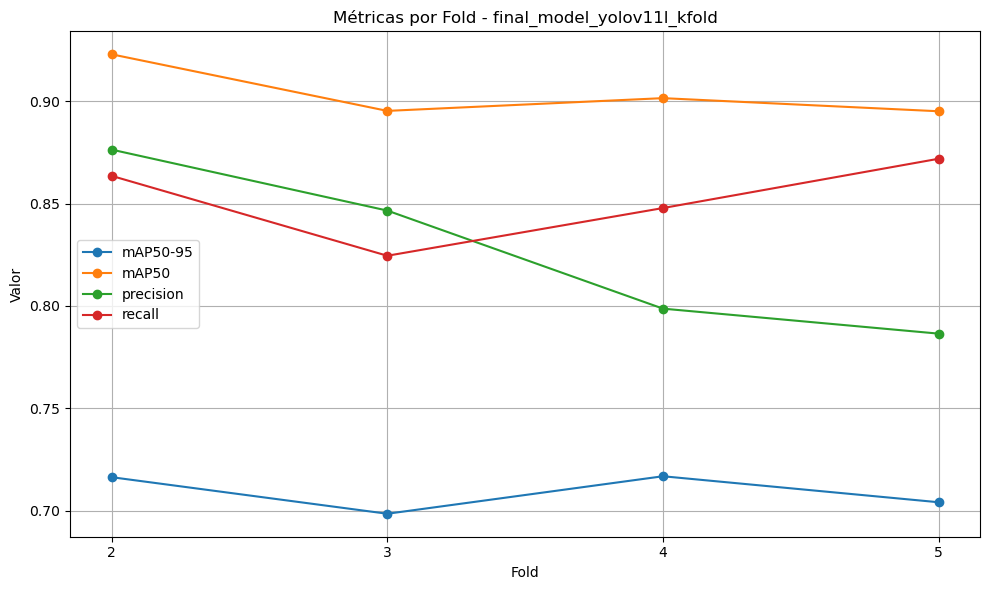

In [ ]:
kfold_utils.plot_kfold_metrics(metrics_df, model_output_kfold)

### **Train**

In [6]:
model.train(
    data="cells.yaml",
    epochs=config.EPOCH_TRAIN,   
    imgsz=config.IMGSZ,          
    batch=config.BATCH,           
    name=model_output,
    save=True,         
    **best_params      
)

New https://pypi.org/project/ultralytics/8.3.169 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=cells.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=704, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00019010245319870352, lrf=0.001959497205867916, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov9s.pt, momentum=0.8549542764940538, mosaic=1.0, multi_scale=False, name

100%|██████████| 5.35M/5.35M [00:00<00:00, 24.6MB/s]


AMP: checks passed 
train: Fast image access  (ping: 0.10.0 ms, read: 143.534.1 MB/s, size: 105.3 KB)


train: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\train\labels.cache... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.30.0 ms, read: 186.532.0 MB/s, size: 109.0 KB)


val: Scanning C:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor García Blanco\03.Datasets\YOLO_Datasets\split\val\labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]


Plotting labels to runs\detect\final_model_yolov9s\labels.jpg... 
optimizer: SGD(lr=0.00019010245319870352, momentum=0.8549542764940538) with parameter groups 221 weight(decay=0.0), 228 weight(decay=0.0002679422874194002), 227 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\detect\final_model_yolov9s
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60       3.7G      2.757      5.166      1.341        133        704: 100%|██████████| 28/28 [00:32<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]

                   all         70        889    0.00943      0.223    0.00681    0.00318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      3.73G      2.488      3.904      1.217        256        704: 100%|██████████| 28/28 [00:38<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all         70        889      0.217      0.129     0.0842     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      3.85G      2.313      2.744      1.154        230        704: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all         70        889      0.476      0.363      0.355      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      3.88G      2.135      2.227      1.102        168        704: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all         70        889      0.603      0.498      0.507      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60       3.8G      2.018      1.938      1.047        163        704: 100%|██████████| 28/28 [00:23<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]

                   all         70        889      0.634      0.556      0.584      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      3.82G      1.979      1.786      1.035        263        704: 100%|██████████| 28/28 [00:31<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]

                   all         70        889      0.635      0.624      0.635      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      3.88G      1.885      1.651      1.011        188        704: 100%|██████████| 28/28 [00:34<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         70        889      0.664      0.643       0.67      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      3.79G      1.748      1.503     0.9753        168        704: 100%|██████████| 28/28 [00:27<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all         70        889       0.69      0.649      0.702      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60       3.7G      1.694      1.402     0.9612        184        704: 100%|██████████| 28/28 [00:28<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all         70        889      0.695      0.691      0.715      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      3.92G      1.581      1.317     0.9442        149        704: 100%|██████████| 28/28 [00:38<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        889      0.716      0.716      0.748      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      3.89G      1.522      1.276      0.929        164        704: 100%|██████████| 28/28 [00:30<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        889      0.743      0.686      0.749      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      3.87G      1.526      1.239     0.9187        219        704: 100%|██████████| 28/28 [00:32<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        889      0.749       0.72      0.771      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      3.85G      1.434      1.152     0.9072        171        704: 100%|██████████| 28/28 [00:34<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        889      0.706      0.754      0.769      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      3.72G      1.432      1.126     0.9062         95        704: 100%|██████████| 28/28 [00:25<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        889      0.726       0.77      0.793      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      3.85G      1.407      1.093     0.8942        247        704: 100%|██████████| 28/28 [00:28<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        889      0.759       0.74      0.797      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      3.75G       1.42       1.09        0.9        206        704: 100%|██████████| 28/28 [00:25<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         70        889      0.775      0.704      0.791      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      3.96G      1.424      1.095     0.8907        303        704: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all         70        889      0.759      0.724      0.787      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      3.81G      1.375      1.052     0.8861        238        704: 100%|██████████| 28/28 [00:30<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all         70        889      0.762      0.746        0.8      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60       3.9G       1.32      1.024      0.892        374        704: 100%|██████████| 28/28 [00:29<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        889      0.778      0.745      0.807      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      3.94G      1.335      1.022     0.8741        118        704: 100%|██████████| 28/28 [00:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]

                   all         70        889      0.757      0.765      0.801      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60       3.8G      1.299     0.9859     0.8752        191        704: 100%|██████████| 28/28 [00:33<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        889      0.766      0.757      0.814       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      3.68G       1.29     0.9855     0.8756        169        704: 100%|██████████| 28/28 [00:19<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        889      0.783      0.758      0.819      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      3.81G      1.289     0.9895     0.8654        171        704: 100%|██████████| 28/28 [00:25<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        889      0.771      0.764      0.821      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      3.68G      1.275     0.9728     0.8741        175        704: 100%|██████████| 28/28 [00:27<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        889      0.787      0.764      0.824      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      3.84G      1.276     0.9684     0.8682        349        704: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all         70        889      0.797      0.746      0.823      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      3.77G      1.259       0.95     0.8763        117        704: 100%|██████████| 28/28 [00:38<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

                   all         70        889        0.8      0.742      0.825      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      3.74G      1.296     0.9642     0.8738        297        704: 100%|██████████| 28/28 [00:48<00:00,  1.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        889      0.813      0.746      0.828       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      3.69G      1.222     0.9474     0.8754        163        704: 100%|██████████| 28/28 [00:35<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        889      0.803       0.75      0.825      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      3.78G      1.256     0.9221     0.8646        246        704: 100%|██████████| 28/28 [00:36<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]

                   all         70        889      0.811      0.751      0.829      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      3.81G      1.249     0.9226     0.8587        196        704: 100%|██████████| 28/28 [00:35<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

                   all         70        889      0.779       0.77      0.828      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      3.86G      1.218      0.955     0.8658        310        704: 100%|██████████| 28/28 [00:49<00:00,  1.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]

                   all         70        889      0.773      0.774       0.82       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      3.61G      1.181     0.8947     0.8572        158        704: 100%|██████████| 28/28 [00:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        889      0.794      0.763      0.824      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      3.82G      1.235     0.9103      0.865        248        704: 100%|██████████| 28/28 [00:32<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all         70        889      0.803      0.757      0.822      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60      3.81G      1.245     0.8991      0.867        240        704: 100%|██████████| 28/28 [00:31<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]

                   all         70        889      0.795      0.767      0.828      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60      3.88G      1.228     0.8875     0.8626        184        704: 100%|██████████| 28/28 [00:40<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        889      0.789      0.772      0.828      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60      3.82G      1.206     0.8889     0.8553        214        704: 100%|██████████| 28/28 [00:35<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

                   all         70        889      0.795       0.76      0.827      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60      3.66G      1.195     0.8854      0.856        159        704: 100%|██████████| 28/28 [00:36<00:00,  1.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.24it/s]

                   all         70        889      0.807      0.763      0.832      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60      3.68G      1.161     0.8641     0.8558        235        704: 100%|██████████| 28/28 [00:27<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all         70        889       0.81      0.762      0.831      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60      3.78G      1.187     0.8652     0.8525        214        704: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]

                   all         70        889      0.816      0.764      0.831      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60      3.88G      1.198     0.8757     0.8552        237        704: 100%|██████████| 28/28 [00:58<00:00,  2.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all         70        889      0.808      0.769      0.835      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60      3.94G      1.145     0.8281     0.8518        220        704: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        889      0.822      0.765      0.836      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60         4G      1.226     0.8725     0.8543        195        704: 100%|██████████| 28/28 [00:45<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]

                   all         70        889      0.823      0.764      0.839      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60      3.79G      1.177     0.8517     0.8574        164        704: 100%|██████████| 28/28 [00:29<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        889      0.815      0.761      0.837      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60      3.82G      1.168     0.8494     0.8517        309        704: 100%|██████████| 28/28 [00:43<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

                   all         70        889      0.813      0.765      0.835      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60      3.89G      1.212     0.8912     0.8597        193        704: 100%|██████████| 28/28 [00:39<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all         70        889      0.813      0.764      0.834      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60      3.85G      1.224     0.8583     0.8626        252        704: 100%|██████████| 28/28 [00:29<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all         70        889      0.816      0.766      0.836      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60      3.72G      1.186     0.8677     0.8515        201        704: 100%|██████████| 28/28 [00:23<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all         70        889      0.818      0.767      0.836      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60      3.72G      1.208     0.8533      0.855        217        704: 100%|██████████| 28/28 [00:29<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        889      0.815      0.764      0.839      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60      3.96G       1.17     0.8492     0.8457        210        704: 100%|██████████| 28/28 [00:50<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]

                   all         70        889      0.826       0.76       0.84      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60       3.9G      1.152     0.8441     0.8488        254        704: 100%|██████████| 28/28 [00:33<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]

                   all         70        889      0.818      0.758      0.839      0.598


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60      3.64G       1.14     0.9619     0.8506         49        704: 100%|██████████| 28/28 [00:31<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]

                   all         70        889      0.784      0.768      0.817      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60      3.71G      1.121     0.9135     0.8515        173        704: 100%|██████████| 28/28 [00:29<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        889      0.725      0.784      0.793      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60      3.69G       1.14      0.934      0.852        221        704: 100%|██████████| 28/28 [00:33<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all         70        889      0.718        0.8      0.792      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60      3.62G      1.094     0.8888     0.8475        116        704: 100%|██████████| 28/28 [00:32<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all         70        889      0.751      0.772      0.807      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60      3.61G      1.108       0.87     0.8515         68        704: 100%|██████████| 28/28 [00:34<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all         70        889      0.766      0.778      0.813      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60      3.69G      1.126     0.8753     0.8546        184        704: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

                   all         70        889      0.769      0.773      0.815      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60      3.63G      1.059     0.8365     0.8448        108        704: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        889       0.78       0.76      0.816      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60       3.7G      1.141     0.8687     0.8423        126        704: 100%|██████████| 28/28 [00:32<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all         70        889      0.761      0.782      0.818      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60      3.65G      1.101      0.853     0.8512         58        704: 100%|██████████| 28/28 [00:34<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all         70        889      0.775      0.772      0.819      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60      3.67G      1.075     0.8701     0.8511         67        704: 100%|██████████| 28/28 [00:26<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

                   all         70        889      0.783      0.759      0.818      0.562



60 epochs completed in 0.639 hours.
Optimizer stripped from runs\detect\final_model_yolov9s\weights\last.pt, 15.2MB
Optimizer stripped from runs\detect\final_model_yolov9s\weights\best.pt, 15.2MB

Validating runs\detect\final_model_yolov9s\weights\best.pt...
Ultralytics 8.3.168  Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv9s summary (fused): 197 layers, 7,167,475 parameters, 0 gradients, 26.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


                   all         70        889      0.816      0.765      0.839      0.598
Speed: 0.6ms preprocess, 16.3ms inference, 0.0ms loss, 8.7ms postprocess per image
Results saved to runs\detect\final_model_yolov9s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F648A1B550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

### **Train Plots**

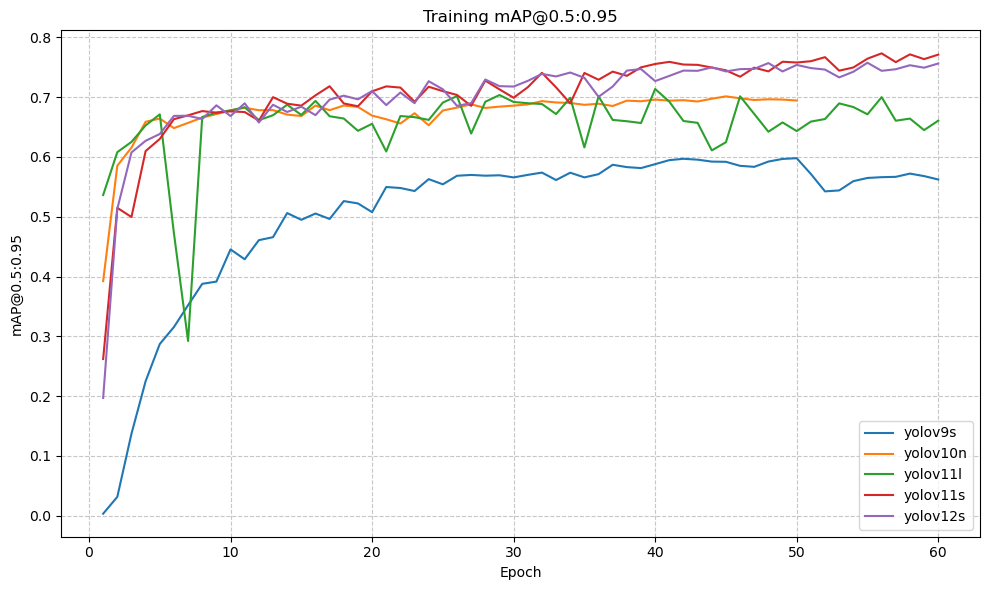

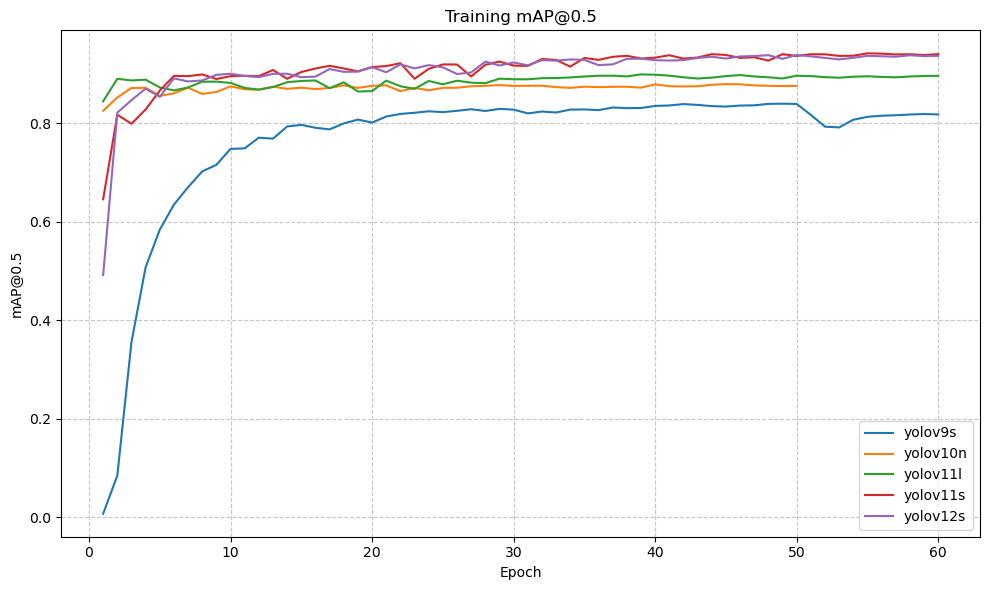

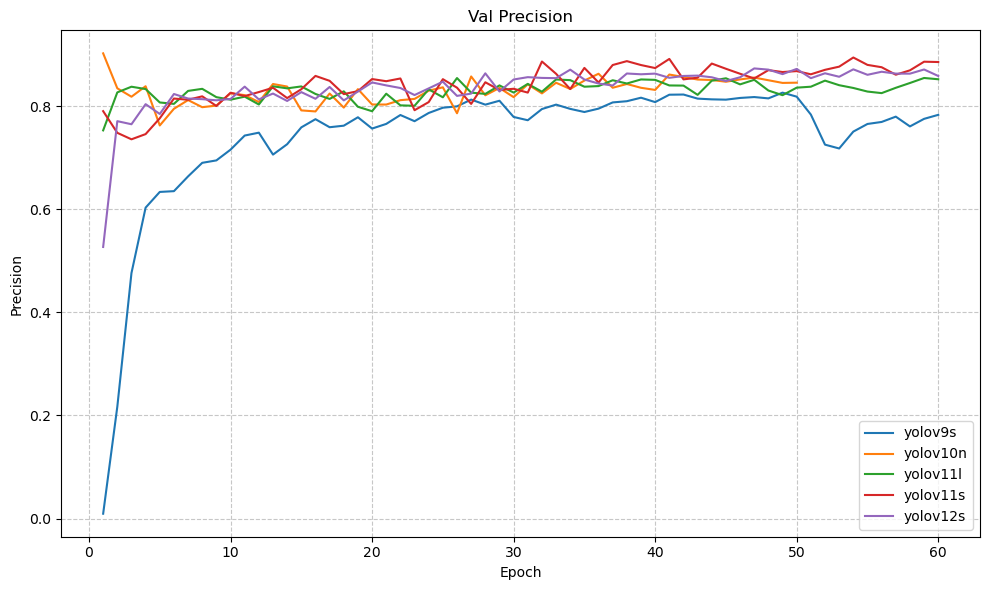

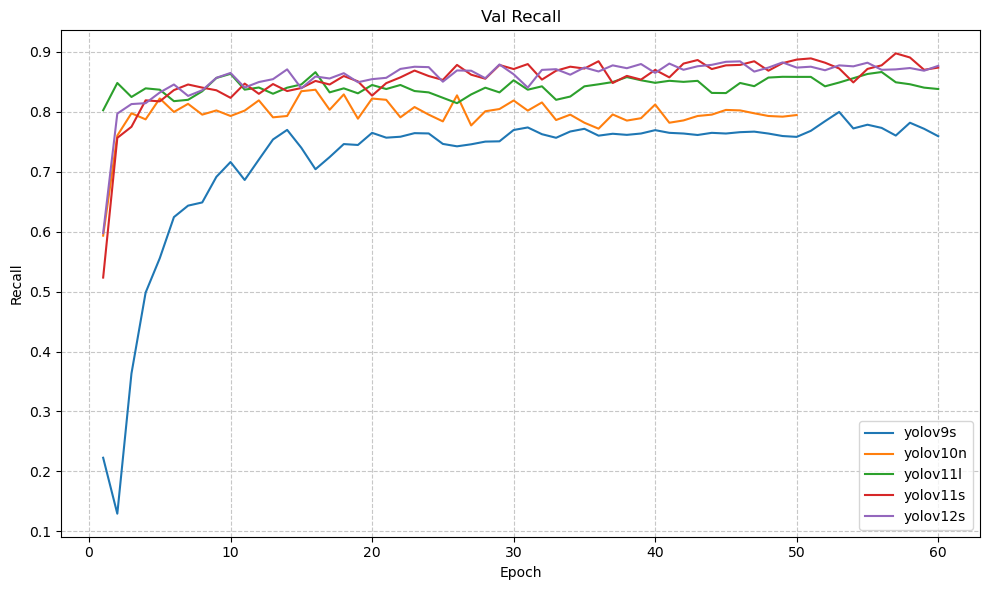

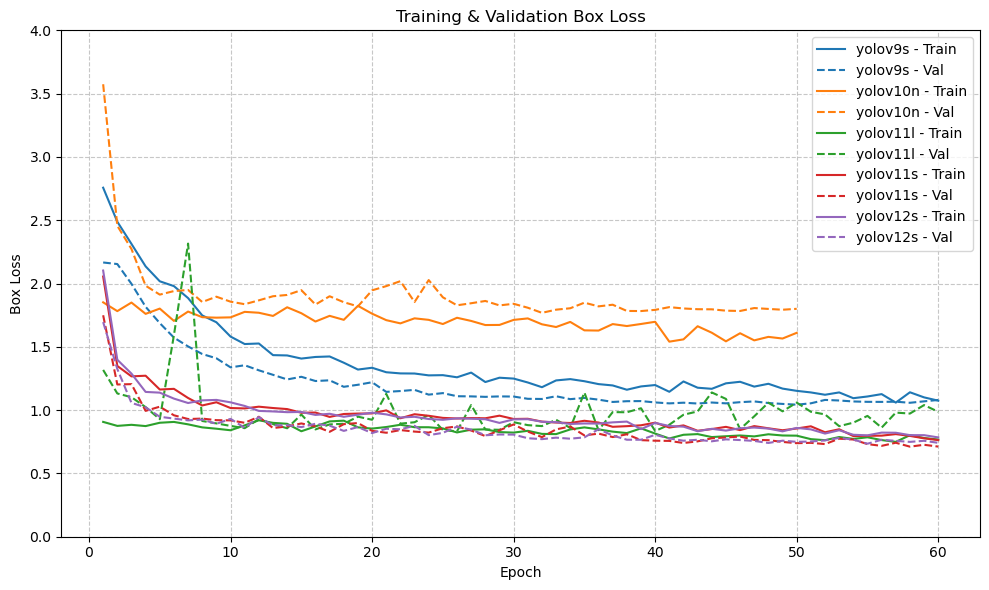

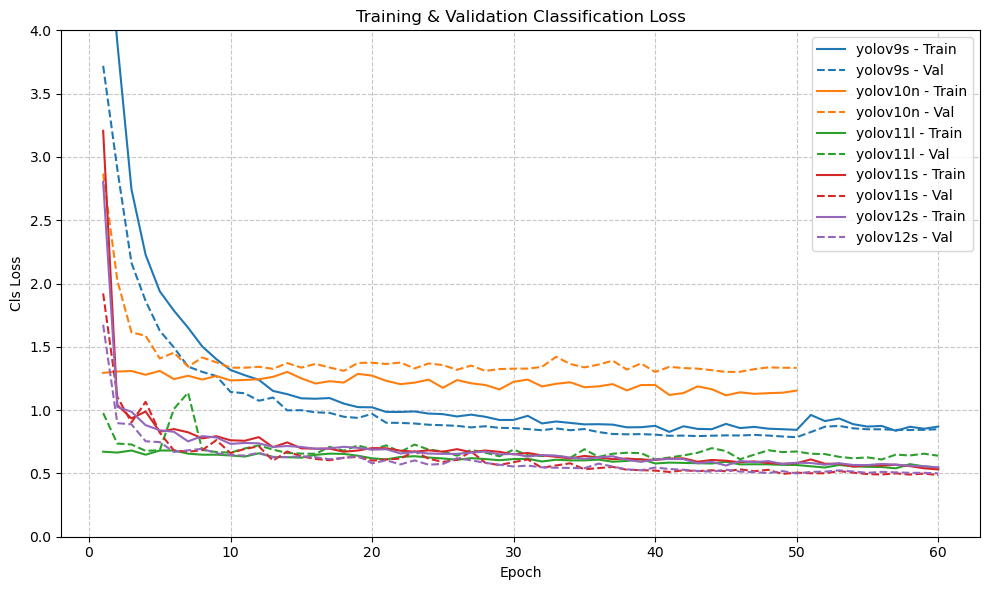

In [5]:
plots_dir = 'yolo_output/yolo_plots'
dfs = plot_utils.load_experiment_results(config.results_csv_paths)

plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50-95', 'metrics/mAP50-95(B)', 'Training mAP@0.5:0.95', 'mAP@0.5:0.95')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'map50', 'metrics/mAP50(B)', 'Training mAP@0.5', 'mAP@0.5')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'precision', 'metrics/precision(B)', 'Val Precision', 'Precision')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'recall', 'metrics/recall(B)', 'Val Recall', 'Recall')
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'box_loss', ['train/box_loss', 'val/box_loss'], 
                               'Training & Validation Box Loss', 'Box Loss', True, (0, 4))
plot_utils.create_and_save_individual_plot(dfs, plots_dir,'cls_loss', ['train/cls_loss', 'val/cls_loss'], 
                               'Training & Validation Classification Loss', 'Cls Loss', True, (0, 4))

## **Evaluaciones de empresa**

In [ ]:
def process_images(directorio_entrada, directorio_referencia, directorio_salida, modelo_path):
    """
    Process all images in a directory with YOLO and compare with reference images.
    
    Args:
        directorio_entrada: Path to directory containing input images
        directorio_referencia: Path to directory containing reference images
        directorio_salida: Path to save output comparison images
        modelo_path: Path to YOLO model weights
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(directorio_salida):
        os.makedirs(directorio_salida)
        print(f"Directorio creado: {directorio_salida}")
    else:
        print(f"Usando directorio de salida: {directorio_salida}")
    
    modelo_personalizado = YOLO(modelo_path)
    
    archivos_entrada = [f for f in os.listdir(directorio_entrada) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not archivos_entrada:
        print(f"No se encontraron imágenes en {directorio_entrada}")
        return
    
    print(f"Procesando {len(archivos_entrada)} imágenes...")
    
    for nombre_archivo in archivos_entrada:
        print(f"Procesando: {nombre_archivo}")
        ruta_imagen = os.path.join(directorio_entrada, nombre_archivo)
        
        nombre_base = os.path.splitext(nombre_archivo)[0]
        nombre_referencia = f"{nombre_base}_.jpg"
        ruta_imagen_referencia = os.path.join(directorio_referencia, nombre_referencia)
        
        if not os.path.exists(ruta_imagen_referencia):
            print(f"Advertencia: No se encontró la imagen de referencia {nombre_referencia}")
            ruta_imagen_referencia = None
        
        resultados = modelo_personalizado(ruta_imagen)
        
        for r in resultados:
            num_detecciones = len(r.boxes)

            im_array = r.plot(labels=False, conf=True)

            font = cv2.FONT_HERSHEY_SIMPLEX
            texto_contador = f"{num_detecciones}"

            # Calculamos el tamaño del texto para posicionarlo correctamente
            textSize = cv2.getTextSize(texto_contador, font, 0.8, 2)[0]
            
            # Posicionamos en la esquina superior derecha con un margen de 20px
            text_x = im_array.shape[1] - textSize[0] - 20
            text_y = 30  # 30px desde la parte superior
            
            # Dibujamos el texto
            cv2.putText(im_array, texto_contador, (text_x, text_y), font, 0.8, (255, 255, 255), 2)
            
            if ruta_imagen_referencia:
                img_referencia = cv2.imread(ruta_imagen_referencia)
                
                h1, w1 = im_array.shape[:2]
                h2, w2 = img_referencia.shape[:2]
                
                if h1 != h2:
                    if h1 > h2:
                        new_w2 = int(w2 * (h1 / h2))
                        img_referencia = cv2.resize(img_referencia, (new_w2, h1))
                    else:
                        new_w1 = int(w1 * (h2 / h1))
                        im_array = cv2.resize(im_array, (new_w1, h2))
                
                img_combinada = cv2.hconcat([im_array, img_referencia])
                
                cv2.line(img_combinada, (im_array.shape[1], 0), (im_array.shape[1], img_combinada.shape[0]), (90, 70, 255), 2)
                
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(img_combinada, "YOLO", (10, 30), font, 1, (0, 255, 0), 2)
                cv2.putText(img_combinada, "IR", (im_array.shape[1] + 10, 30), font, 1, (0, 255, 0), 2)
                
                ruta_salida = os.path.join(directorio_salida, f"comparacion_{nombre_archivo}")
                cv2.imwrite(ruta_salida, img_combinada)
            else:
                ruta_salida = os.path.join(directorio_salida, f"yolo_{nombre_archivo}")
                cv2.imwrite(ruta_salida, im_array)
            
    print(f"Procesamiento completado. Resultados guardados en {directorio_salida}")

Añadir la evaluación sobre el conjunto de test

In [ ]:
modelo_path = '.\\runs\\detect\\final_model_optunav12s\\weights\\best.pt'

# DEFAULT dataset
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\INPUT DEFAULT",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\OUTPUT_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\DEFAULT\\YOLO_NEW",
    modelo_path
)

# TEST 2
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\INPUT TEST_2",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\OUTPUT_TEST 2_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 2\\YOLO_NEW",
    modelo_path
)

# TEST 3
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\INPUT_TEST 3",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\OUTPUT_TEST 3_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 3\\YOLO_NEW",
    modelo_path
)

# TEST 4
process_images(
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\INPUT_TEST 4",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\OUTPUT_TEST 4_edited",
    "..\\03.Datasets\\Evaluacion_Empresa\\TEST 4\\YOLO_NEW",
    modelo_path
)

Usando directorio de salida: ..\03.Datasets\Evaluacion_Empresa\DEFAULT\YOLO_NEW
Procesando 94 imágenes...
Procesando: 110.jpg
Advertencia: No se encontró la imagen de referencia 110_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\110.jpg: 576x704 1 cell, 80.9ms
Speed: 4.1ms preprocess, 80.9ms inference, 165.2ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 116.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFAULT\INPUT DEFAULT\116.jpg: 576x704 36 cells, 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 704)
Procesando: 124.jpg
Advertencia: No se encontró la imagen de referencia 124_.jpg

image 1/1 c:\Users\mini7\Desktop\Master\Materias\TFM\Laura\2025_MURIA_Aitor Garca Blanco\04.Codigo\..\03.Datasets\Evaluacion_Empresa\DEFA

KeyboardInterrupt: 

añadir kfold y una función general que importe con un import para generar una carpeta con los resultados de la evaluación de cada imagen del test/defalut/eval_empresa 

probar con optuna varios batch con: ``batch = trial.suggest_categorical('batch', [4, 8, 12])`` con los modelos s.

Probar a entrenar Yolo con capas de atención y mucho más personalizados algunos modelos.

 hacer RFHF con yolo?

| Modelo           |  IoU  |  59 imagen  |  61 imagen  |  219 imagen  |  369 imagen  |
|------------------|:-----:|:-----------:|:-----------:|:------------:|:------------:|
| yolov9s_optuna   |  0.5  |     ❌      |     ❌      |      ❌     |      ❌     |
| yolov9s_optuna   |  0.7  |     ✅      |     ✅      |      ❌     |      ❌     |
| yolov10n_optuna  |  0.5  |     ✅      |     ❌      |      ❌     |      ❌     |
| yolov10n_optuna  |  0.7  |     ✅      |     ✅      |      ❌     |      ✅     |
| yolov11s_optuna  |  0.5  |     ✅      |     ❌      |      ❌     |      ✅     |
| yolov11s_optuna  |  0.7  |     ✅      |     ✅      |      ✅     |      ✅     |
| yolov12s_optuna  |  0.5  |     ✅      |     ✅      |      ✅     |      ✅     |
| yolov12s_optuna  |  0.7  |     ✅      |     ✅      |      ✅     |      ✅     |

## **Conclusión**

## **Comentarios reunión semanal**

Para el power point usar el mes gratis de copilot, así lo redacto mejor y más rápido la presentación

"no es posible distinguir entre leucocitos y células germinales inmaduras con un alto grado de certeza (2)" https://pmc.ncbi.nlm.nih.gov/articles/PMC8915675/

Quiero probar este modelo: https://github.com/Peterande/D-FINE?tab=readme-ov-file

comentar en la memoria el uso de linters como ruff